## Algoritmo di Louvain
### Algoritmo euristico: 
Anche se originariamente progettato per il rilevamento di comunità in reti, l'algoritmo di Louvain può essere utilizzato per partizionare un grafo. Esso funziona ottimizzando la modularità, che è una misura della densità degli archi all'interno dei cluster rispetto agli archi tra i cluster. 

dopo il rilevamento iniziale della comunità, lo script controlla se ci sono meno di k cluster. Se ci sono, divide il cluster più grande in due cluster nel tentativo di raggiungere il numero desiderato di cluster (k). La divisione è fatta dividendo il cluster più grande in due metà approssimativamente uguali (nota che è una divisione arbitraria e non una ulteriore applicazione del metodo Louvain o un altro algoritmo di clustering).

## Verifica ammissibilità delle soluzioni ottenute

Per verificare l'ammissibilità della soluzione ottenuta possiamo creare una funzione che esegua i seguenti controlli:

Ogni nodo deve essere in un solo cluster: Possiamo controllare che la somma delle lunghezze dei cluster sia uguale al numero totale di nodi nel grafo.

Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster: Possiamo controllare che per ogni nodo in un cluster, almeno uno dei suoi vicini è anche nel cluster.

Grafo iniziale:
0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Clusters: [[9, 7], [0, 8, 4, 1], [6, 2, 3]]
Dimensione del multi-cut: 4
La soluzione è ammissibile.


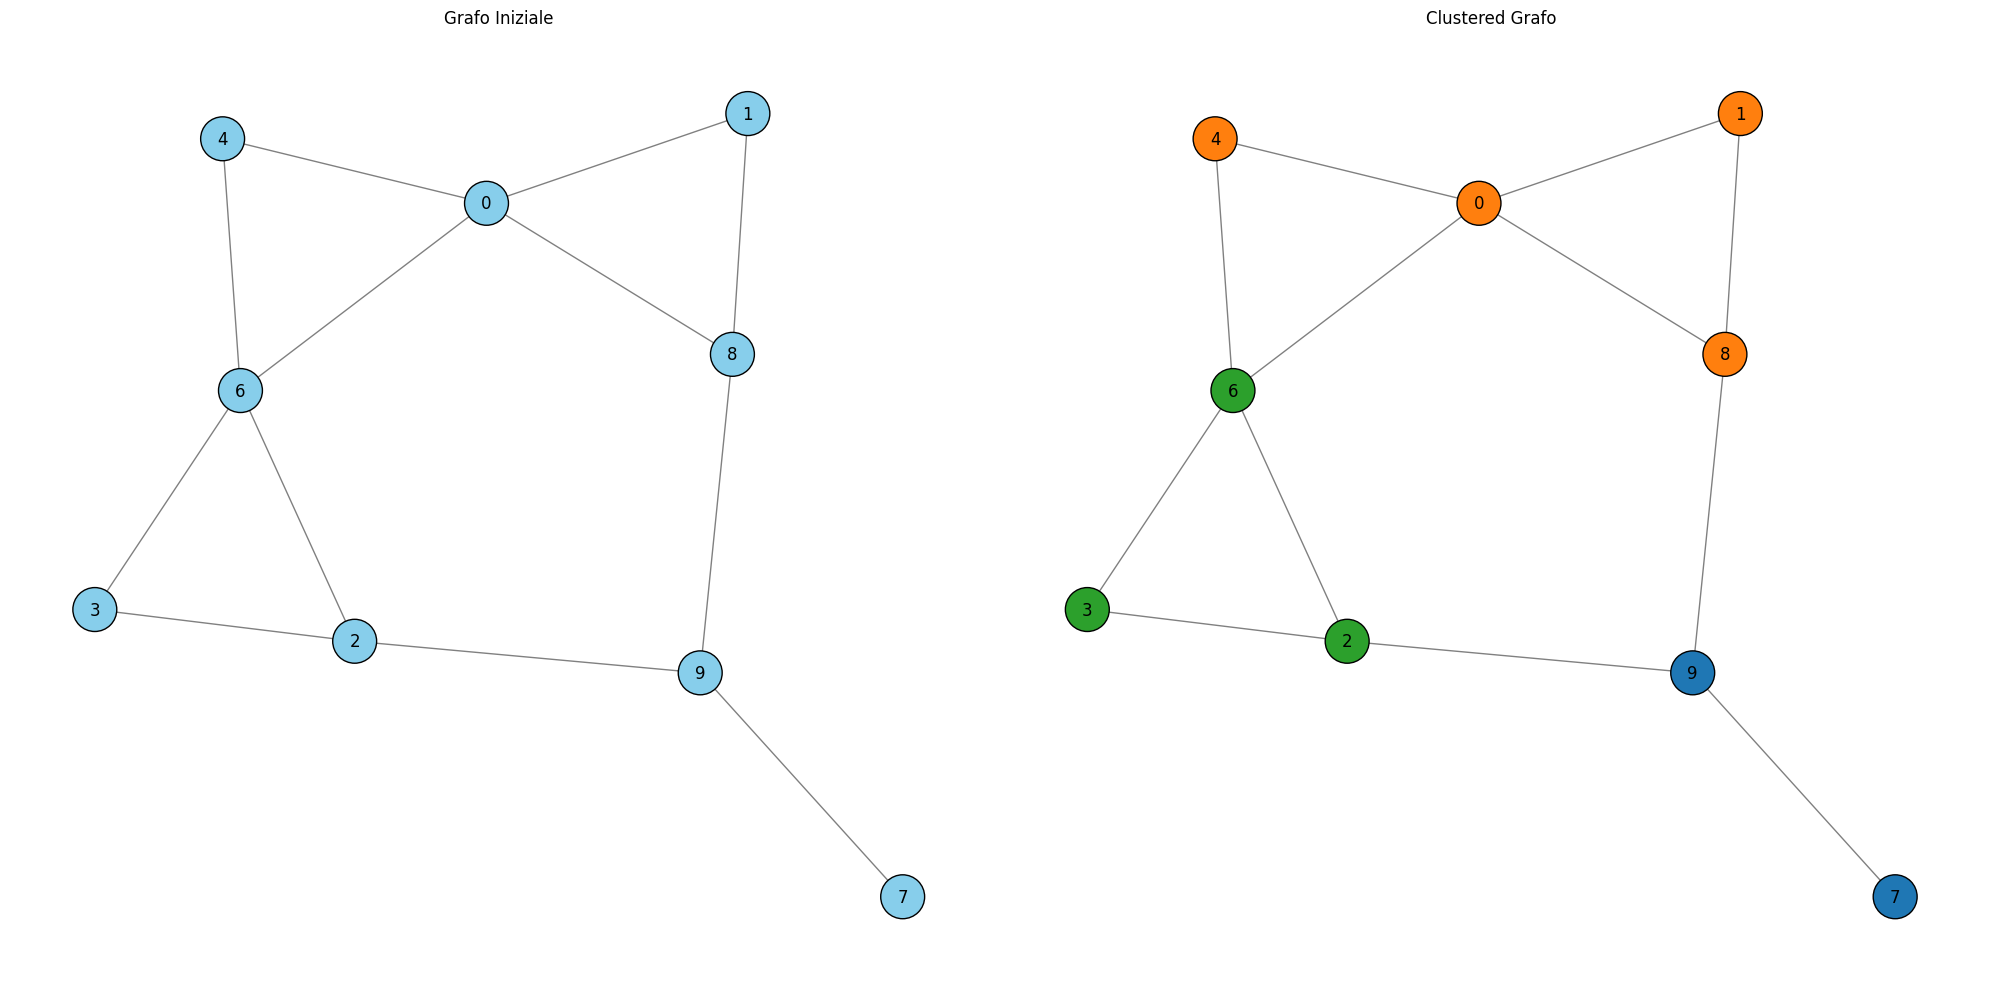

Tempo di esecuzione dell'algoritmo di Louvain: 0.0005784034729003906 secondi.


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from collections import defaultdict
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
""" def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)

    while len([c for c in clusters if c]) < k:
        # Trova il cluster più grande
        max_cluster_index = max(range(k), key=lambda i: len(clusters[i]))
        if len(clusters[max_cluster_index]) < 2:
            # Se il cluster più grande ha meno di due nodi, non può essere diviso
            break
        # Sostituisci il cluster più grande con due nuovi cluster, divisi in modo casuale
        cluster = clusters[max_cluster_index]
        half = len(cluster) // 2
        clusters.append(cluster[:half])
        clusters[max_cluster_index] = cluster[half:]

    return clusters """
    
def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    node_to_cluster = {}
    for node, cluster_index in partition.items():
        if len(clusters[cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[cluster_index]):
            clusters[cluster_index].append(node)
            node_to_cluster[node] = cluster_index
        else:
            # se il nodo non è connesso a nessun altro nodo nel cluster, cerca un altro cluster
            for new_cluster_index in range(k):
                if new_cluster_index != cluster_index and (len(clusters[new_cluster_index]) == 0 or any(graph.has_edge(node, n) for n in clusters[new_cluster_index])):
                    clusters[new_cluster_index].append(node)
                    node_to_cluster[node] = new_cluster_index
                    break
            else:
                # se non esiste un cluster adatto, crea uno nuovo
                clusters.append([node])
                node_to_cluster[node] = len(clusters) - 1

    # Unisci i cluster più piccoli fino a raggiungere il numero desiderato di cluster
    while len([c for c in clusters if c]) > k:
        # Trova il cluster più piccolo
        min_cluster_index = min(range(len(clusters)), key=lambda i: len(clusters[i]) if clusters[i] else float('inf'))
        min_cluster = clusters[min_cluster_index]
        clusters[min_cluster_index] = []
        # Trova il cluster con il maggior numero di connessioni con il cluster più piccolo
        connections = defaultdict(int)
        for node in min_cluster:
            for neighbor in graph.neighbors(node):
                if neighbor in node_to_cluster:
                    connections[node_to_cluster[neighbor]] += 1
        max_connections_index = max(connections, key=connections.get)
        # Unisci i due cluster
        clusters[max_connections_index].extend(min_cluster)
        for node in min_cluster:
            node_to_cluster[node] = max_connections_index

    return [c for c in clusters if c]

def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2

def check_solution(graph, clusters):
    total_nodes = sum(len(cluster) for cluster in clusters)
    if total_nodes != graph.number_of_nodes():
        print("Ogni nodo deve essere in un solo cluster.")
        return False

    for cluster in clusters:
        for node in cluster:
            node_neighbors = set(graph.neighbors(node))
            cluster_set = set(cluster)
            if not node_neighbors & cluster_set:
                print("Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster.")
                return False

    multicut_size = calculate_multicut_size(graph, clusters)
    print("Dimensione del multi-cut:", multicut_size)

    print("La soluzione è ammissibile.")
    return True



if __name__ == "__main__":
    grafo = Graph()
    for i in range(10):
        grafo.aggiungi_vertice(i)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)
    
    grafo.rimuovi_vertice(5)
    print("Grafo iniziale:")
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)

    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    clusters = divide_into_clusters(G_initial, k)
    # clusters, edge_count = divide_into_clusters(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    clusters = divide_into_clusters(G_initial, k)
    print("Clusters:", clusters)
    check_solution(G_initial, clusters)

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")
    
    

Grafo iniziale:
0 -> 1, 2
1 -> 0, 2
2 -> 0, 1, 3
3 -> 4, 5, 2
4 -> 3, 5
5 -> 3, 4, 6
6 -> 7, 8, 5
7 -> 6, 8
8 -> 6, 7, 9
9 -> 10, 11, 8
10 -> 9, 11
11 -> 9, 10, 12
12 -> 11, 13
13 -> 12, 14
14 -> 13, 15
15 -> 14
Clusters: [[3, 4, 5, 0, 1, 2], [6, 7, 8], [9, 10, 11], [12, 13, 14, 15]]
Dimensione del multi-cut: 3
La soluzione è ammissibile.


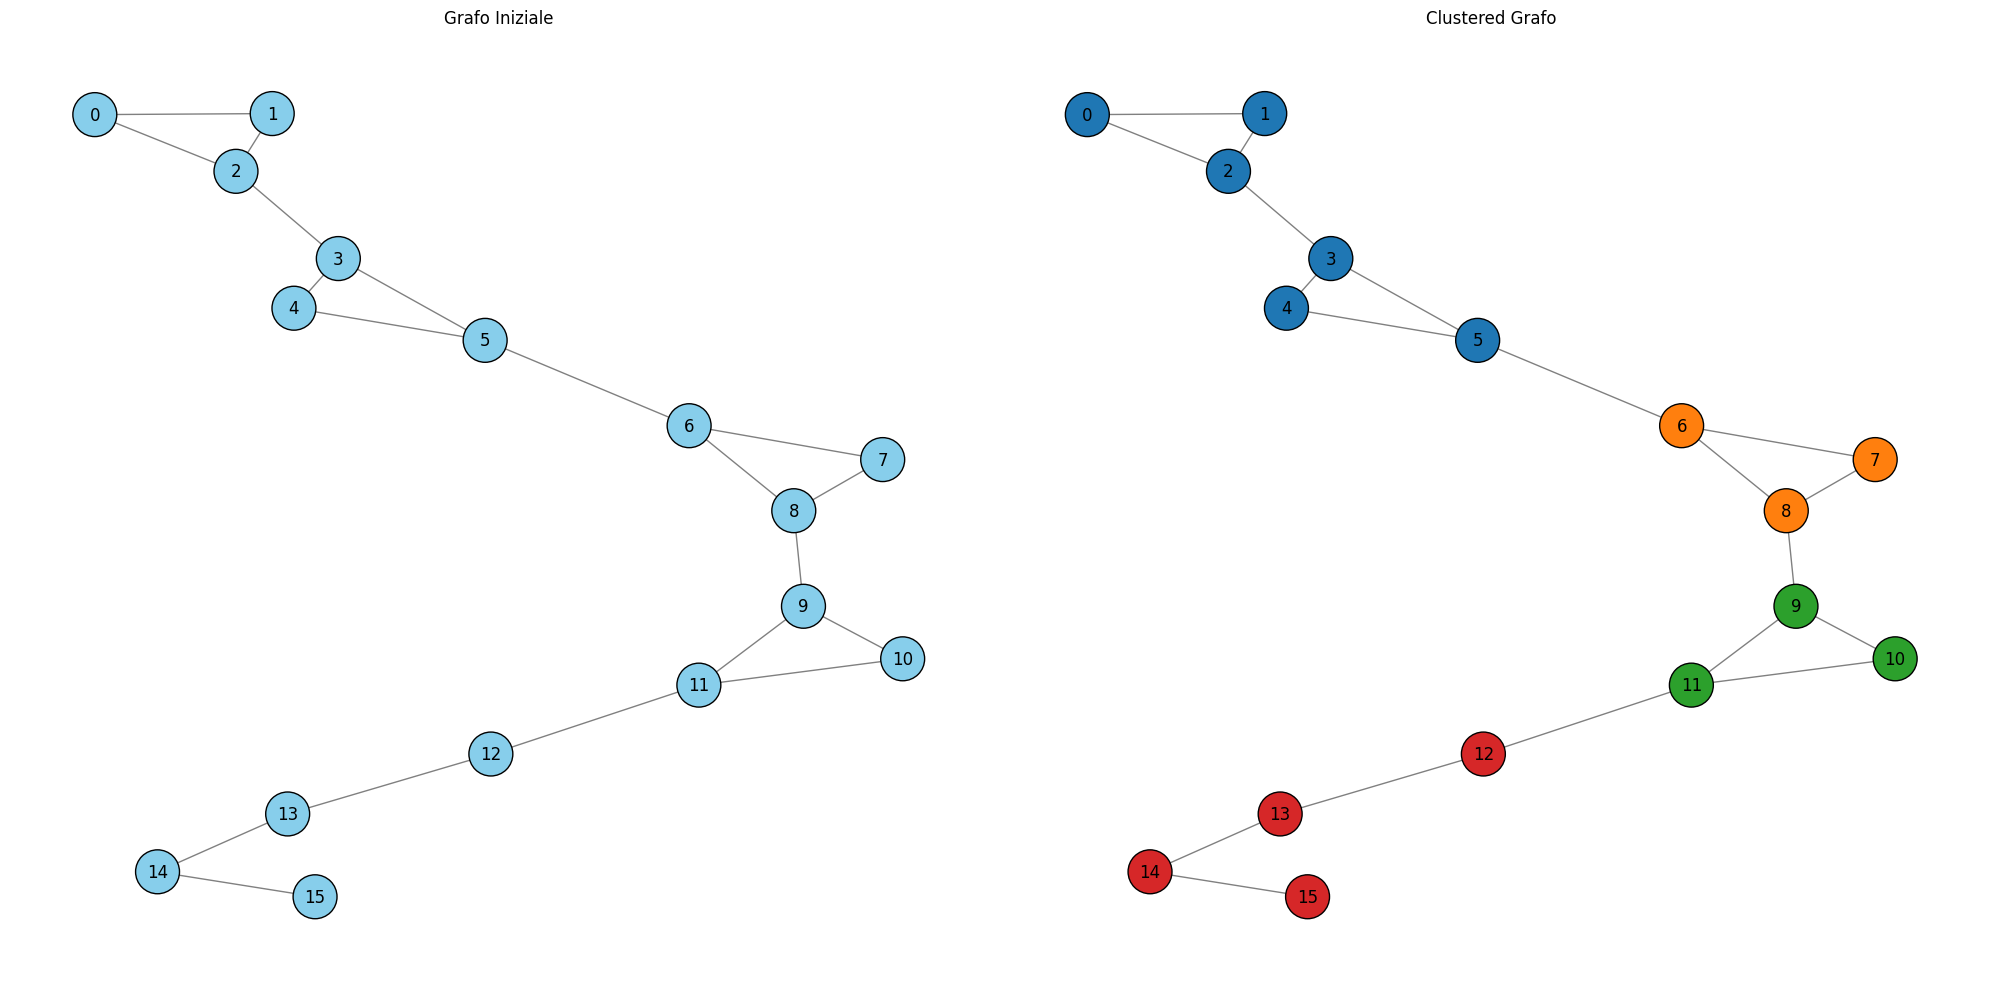

Tempo di esecuzione dell'algoritmo di Louvain: 0.06035447120666504 secondi.


In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from collections import defaultdict
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
def divide_into_clusters(graph):
    partition = community_louvain.best_partition(graph)
    clusters = defaultdict(list)
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)
    return list(clusters.values())

def divide_into_clusters_fixed_k(graph, k):
    # Get the initial division into clusters
    clusters = divide_into_clusters(graph)

    # If there are already k clusters, return them
    if len(clusters) == k:
        return clusters

    # If there are more than k clusters, combine the smallest ones
    if len(clusters) > k:
        while len(clusters) > k:
            # Find the smallest cluster
            smallest_cluster = min(clusters, key=len)
            clusters.remove(smallest_cluster)
            # Find the cluster with which the smallest one shares the most edges
            max_shared_edges = 0
            for cluster in clusters:
                shared_edges = sum(1 for node in smallest_cluster if set(graph.neighbors(node)) & set(cluster))
                if shared_edges > max_shared_edges:
                    max_shared_edges = shared_edges
                    best_cluster_to_combine = cluster
            # Combine the clusters
            best_cluster_to_combine.extend(smallest_cluster)
        return clusters

    # If there are less than k clusters, split the largest ones
    if len(clusters) < k:
        while len(clusters) < k:
            # Find the largest cluster
            largest_cluster = max(clusters, key=len)
            clusters.remove(largest_cluster)
            # Find the node with the most connections outside the cluster
            max_external_connections = 0
            for node in largest_cluster:
                external_connections = sum(1 for neighbor in graph.neighbors(node) if neighbor not in largest_cluster)
                if external_connections > max_external_connections:
                    max_external_connections = external_connections
                    best_node_to_move = node
            # Create a new cluster with this node
            new_cluster = [best_node_to_move]
            largest_cluster.remove(best_node_to_move)
            # Move the nodes connected to the new cluster's node from the old cluster to the new one
            for node in list(largest_cluster):  # Copy the list to avoid problems while removing elements
                if best_node_to_move in graph.neighbors(node):
                    new_cluster.append(node)
                    largest_cluster.remove(node)
            # Add the modified and new clusters
            clusters.append(largest_cluster)
            clusters.append(new_cluster)
        return clusters


def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2

def check_solution(graph, clusters):
    total_nodes = sum(len(cluster) for cluster in clusters)
    if total_nodes != graph.number_of_nodes():
        print("Ogni nodo deve essere in un solo cluster.")
        return False

    for cluster in clusters:
        for node in cluster:
            node_neighbors = set(graph.neighbors(node))
            cluster_set = set(cluster)
            if not node_neighbors & cluster_set:
                print("Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster.")
                return False

    multicut_size = calculate_multicut_size(graph, clusters)
    print("Dimensione del multi-cut:", multicut_size)

    print("La soluzione è ammissibile.")
    return True

if __name__ == "__main__":

    grafo = Graph()
    for i in range(16):
        grafo.aggiungi_vertice(i)

    # Aggiungiamo archi per formare 4 cluster distinti
    # Primo cluster
    grafo.aggiungi_arco(0, 1)
    grafo.aggiungi_arco(0, 2)
    grafo.aggiungi_arco(1, 2)

    # Secondo cluster
    grafo.aggiungi_arco(3, 4)
    grafo.aggiungi_arco(3, 5)
    grafo.aggiungi_arco(4, 5)

    # Terzo cluster
    grafo.aggiungi_arco(6, 7)
    grafo.aggiungi_arco(6, 8)
    grafo.aggiungi_arco(7, 8)

    # Quarto cluster
    grafo.aggiungi_arco(9, 10)
    grafo.aggiungi_arco(9, 11)
    grafo.aggiungi_arco(10, 11)

    # Aggiungiamo qualche arco tra i cluster per rendere il grafo connesso
    grafo.aggiungi_arco(2, 3)
    grafo.aggiungi_arco(5, 6)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(11, 12)
    grafo.aggiungi_arco(12, 13)
    grafo.aggiungi_arco(13, 14)
    grafo.aggiungi_arco(14, 15)

    print("Grafo iniziale:")
    grafo.stampa_grafo() 



    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)

    plot_graph(G_initial, "Grafo Iniziale", 121)

   
    start_time = time.time()
    clusters = divide_into_clusters_fixed_k(G_initial,k=4)
   
    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Clusters:", clusters)
    check_solution(G_initial, clusters)

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")


## Fissiamo k

Questo è un approccio molto semplice che esegue l'algoritmo di Louvain su ogni cluster risultante fino a quando non si raggiunge il numero desiderato di cluster. Questo non garantisce che il risultato sarà ottimale in termini di modularità o di altre misure di qualità del clustering


Grafo iniziale:
0 -> 1, 2
1 -> 0, 2
2 -> 0, 1, 3
3 -> 4, 5, 2
4 -> 3, 5
5 -> 3, 4, 6
6 -> 7, 8, 5
7 -> 6, 8
8 -> 6, 7, 9
9 -> 10, 11, 8
10 -> 9, 11
11 -> 9, 10, 12
12 -> 11, 13
13 -> 12, 14
14 -> 13, 15
15 -> 14


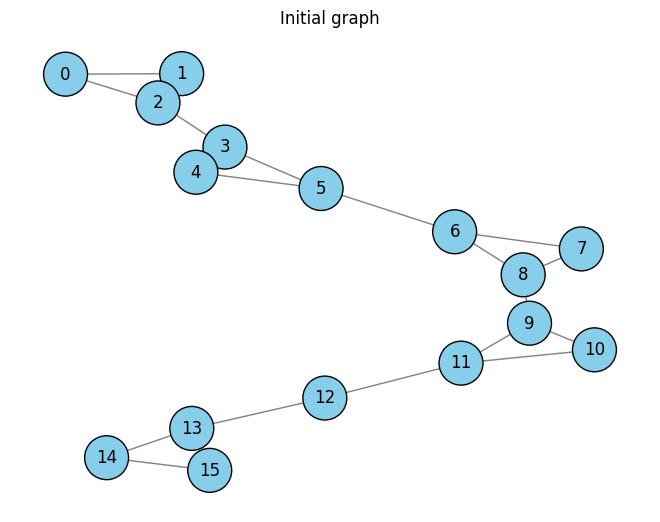

Cluster correnti: [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11, 12, 13, 14, 15]]
Cluster correnti: [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14, 15]]
Cluster [0, 1, 2] è più connesso con altri cluster che al suo interno
Cluster [3, 4, 5] è più connesso con altri cluster che al suo interno
Cluster [6, 7, 8] è più connesso con altri cluster che al suo interno
Cluster [9, 10, 11] è più connesso con altri cluster che al suo interno
Cluster [12, 13, 14, 15] è più connesso con altri cluster che al suo interno
Elapsed time for fixed k division: 0.0012793540954589844 seconds


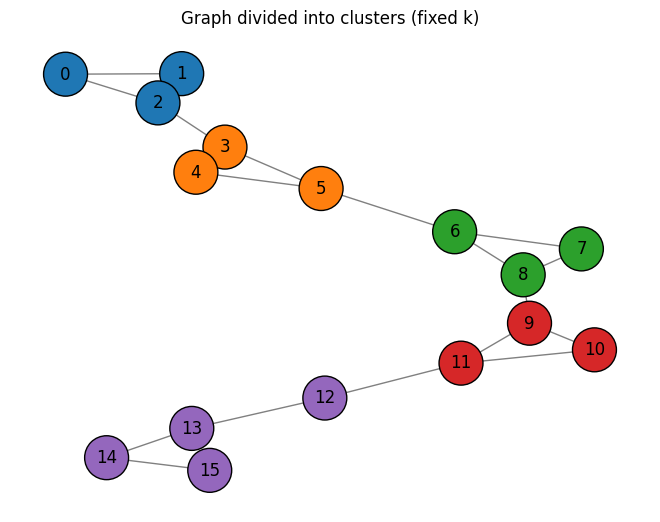

Cluster [0, 1, 2] è più connesso con altri cluster che al suo interno
Cluster [3, 4, 5] è più connesso con altri cluster che al suo interno
Cluster [6, 7, 8] è più connesso con altri cluster che al suo interno
Cluster [9, 10, 11] è più connesso con altri cluster che al suo interno
Cluster [12, 13, 14, 15] è più connesso con altri cluster che al suo interno
Multicut size: 4


In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from collections import defaultdict
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)

    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

def divide_into_clusters_fixed_k(graph, k):
    current_clusters = [list(graph.nodes())]
    while len(current_clusters) < k:
        largest_cluster_index = max(range(len(current_clusters)), key=lambda index: len(current_clusters[index]))
        largest_cluster = current_clusters[largest_cluster_index]
        if len(largest_cluster) < 2:
            break
        subgraph = graph.subgraph(largest_cluster)
        partition = community_louvain.best_partition(subgraph)
        new_clusters = defaultdict(list)
        for node, cluster_index in partition.items():
            new_clusters[cluster_index].append(node)
        new_clusters = list(new_clusters.values())
        if len(new_clusters) > 1:
            current_clusters[largest_cluster_index] = new_clusters[0]
            for new_cluster in new_clusters[1:]:
                current_clusters.append(new_cluster)   # Aggiungiamo sempre i nuovi cluster
        else:
            break
        print("Cluster correnti:", current_clusters)

    while len(current_clusters) > k:
        # trova i due cluster più piccoli
        smallest_clusters_indices = sorted(range(len(current_clusters)), key=lambda index: len(current_clusters[index]))[:2]
        # uniscili
        current_clusters[smallest_clusters_indices[0]] += current_clusters[smallest_clusters_indices[1]]
        # rimuovi il secondo cluster più piccolo
        current_clusters.pop(smallest_clusters_indices[1])

    check_clusters(graph, current_clusters)
    return current_clusters


def check_clusters(graph, clusters):
    # Check that each node belongs to exactly one cluster
    all_nodes = set(graph.nodes())
    for cluster in clusters:
        for node in cluster:
            if node in all_nodes:
                all_nodes.remove(node)
            else:
                raise ValueError(f"Node {node} appears in more than one cluster")
    if all_nodes:
        raise ValueError(f"Some nodes are not included in any cluster: {all_nodes}")

    # Check that each cluster has at least two nodes connected by an edge
    for cluster in clusters:
        subgraph = graph.subgraph(cluster)
        if not any(edge for edge in subgraph.edges()):
            print(f"Cluster {cluster} has no edges")

    # Check that each cluster is more connected within itself than with other clusters
    for cluster in clusters:
        subgraph = graph.subgraph(cluster)
        edges_within = len(subgraph.edges())
        edges_to_other_clusters = sum(len(list(graph.edges(node))) for node in cluster) - edges_within
        if edges_to_other_clusters > edges_within:
            print(f"Cluster {cluster} è più connesso con altri cluster che al suo interno")




def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2

def check_solution(graph, clusters, k):
    # Check that the number of clusters does not exceed k
    """  if len(clusters) > k:
        raise ValueError(f"Number of clusters {len(clusters)} exceeds k {k}") """

    # Check the validity of the clusters
    check_clusters(graph, clusters)

    # Print the multicut size
    print(f"Multicut size: {calculate_multicut_size(graph, clusters)}")

if __name__ == "__main__":
   
    grafo = Graph()
    for i in range(16):
        grafo.aggiungi_vertice(i)
    
    # Crea un grafo con la tua classe Graph
    grafo.aggiungi_arco(0, 1)
    grafo.aggiungi_arco(0, 2)
    grafo.aggiungi_arco(1, 2)

    # Secondo cluster
    grafo.aggiungi_arco(3, 4)
    grafo.aggiungi_arco(3, 5)
    grafo.aggiungi_arco(4, 5)

    # Terzo cluster
    grafo.aggiungi_arco(6, 7)
    grafo.aggiungi_arco(6, 8)
    grafo.aggiungi_arco(7, 8)

    # Quarto cluster
    grafo.aggiungi_arco(9, 10)
    grafo.aggiungi_arco(9, 11)
    grafo.aggiungi_arco(10, 11)

    # Aggiungiamo qualche arco tra i cluster per rendere il grafo connesso
    grafo.aggiungi_arco(2, 3)
    grafo.aggiungi_arco(5, 6)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(11, 12)
    grafo.aggiungi_arco(12, 13)
    grafo.aggiungi_arco(13, 14)
    grafo.aggiungi_arco(14, 15)

    print("Grafo iniziale:")
    grafo.stampa_grafo() 


    # Converti il grafo nella classe Graph di Networkx
    G_initial = converti_grafo_personalizzato_in_networkx(grafo)

    # Visualizza il grafo iniziale
    plot_graph(G_initial, 'Initial graph')

    # Divide il grafo in cluster
    start_time = time.time()
    k = 5
    clusters_fixed = divide_into_clusters_fixed_k(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for fixed k division: {elapsed_time} seconds")

    # Visualizza il grafo diviso in cluster
    plot_graph(G_initial, 'Graph divided into clusters (fixed k)', colors=clusters_fixed)

    # Check the solution
    check_solution(G_initial, clusters_fixed, k)


# Greedy

Questo approccio prevede che i cluster più grandi vengano continuamente divisi finché non abbiamo il numero desiderato di cluster. È un approccio "greedy" perché ad ogni passaggio scegliamo semplicemente il cluster più grande e lo dividiamo, senza preoccuparci se questa scelta potrebbe essere ottimale nel lungo termine.

 L'approccio greedy utilizzato è O(n^2) per ogni iterazione, e potresti aver bisogno di n iterazioni nel peggiore dei casi, rendendo l'euristica di complessità 
O(n^3). Questo potrebbe non essere il metodo più efficiente, ma dovrebbe funzionare bene per grafi di dimensioni moderate.

Grafo iniziale:
0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Ammissibile: True
Clusters: [[0, 8, 1, 4, 6, 2], [9], [3], [7]]
Dimensione del Multicut: 5


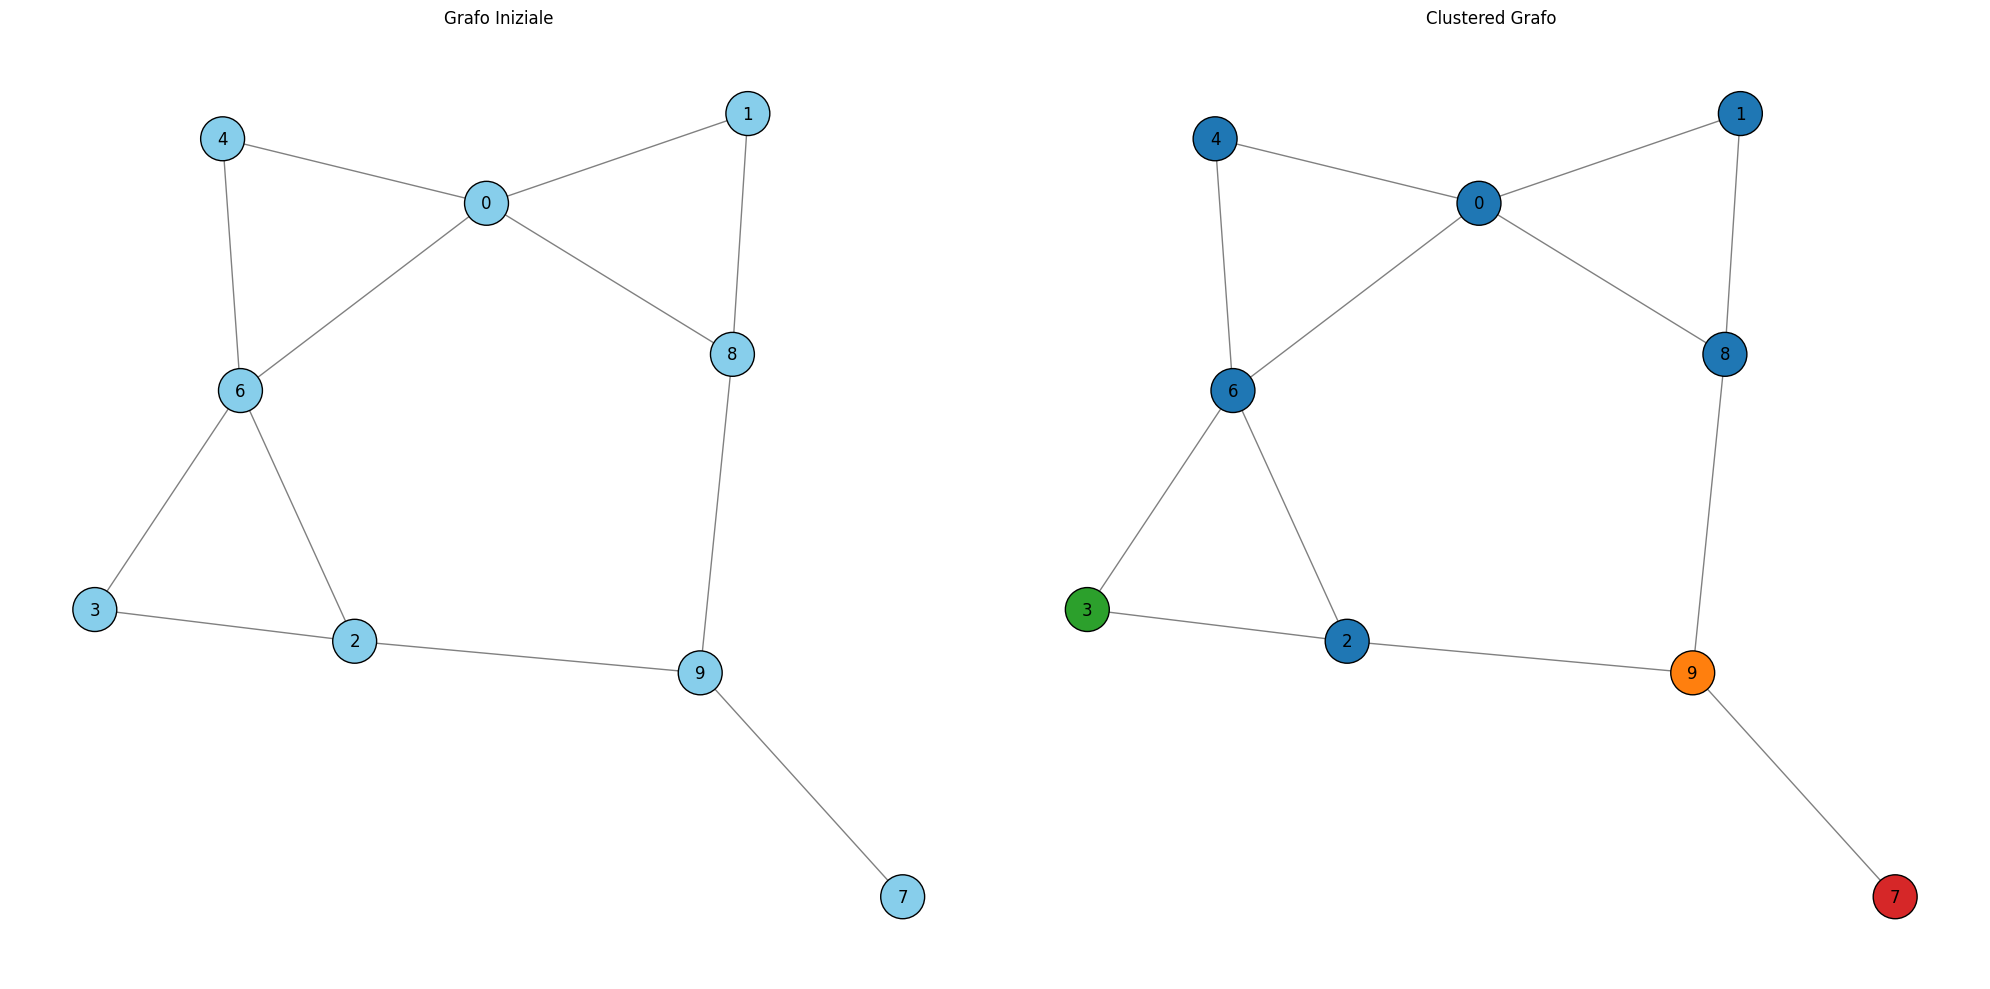

Tempo di esecuzione dell'algoritmo Greedy: 0.0013170242309570312 secondi.


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        sottografo = grafo.subgraph(cluster)
        if not nx.is_connected(sottografo):
            return False
    return True

def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut



if __name__ == "__main__":
    grafo = Graph()
    for i in range(10):
        grafo.aggiungi_vertice(i)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)
    
    grafo.rimuovi_vertice(5)
    
    print("Grafo iniziale:")
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
   
    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    # clusters = divide_into_clusters(G_initial, k)
    clusters = divide_into_clusters_greedy(G_initial, k)
    dimensione_multicut = calcola_dimensione_multicut(G_initial, clusters)
    ammissibile = è_ammissibile(G_initial, clusters)

    print(f"Ammissibile: {ammissibile}")
    print(f"Clusters: {clusters}")
    print(f"Dimensione del Multicut: {dimensione_multicut}")
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo Greedy: {elapsed_time} secondi.")

Grafo iniziale:
0 -> 1, 2
1 -> 0, 2
2 -> 0, 1, 3
3 -> 4, 5, 2
4 -> 3, 5
5 -> 3, 4, 6
6 -> 7, 8, 5
7 -> 6, 8
8 -> 6, 7, 9
9 -> 10, 11, 8
10 -> 9, 11
11 -> 9, 10, 12
12 -> 11, 13
13 -> 12, 14
14 -> 13, 15
15 -> 14
Ammissibile: True
Clusters: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [13], [14], [15]]
Dimensione del Multicut: 3


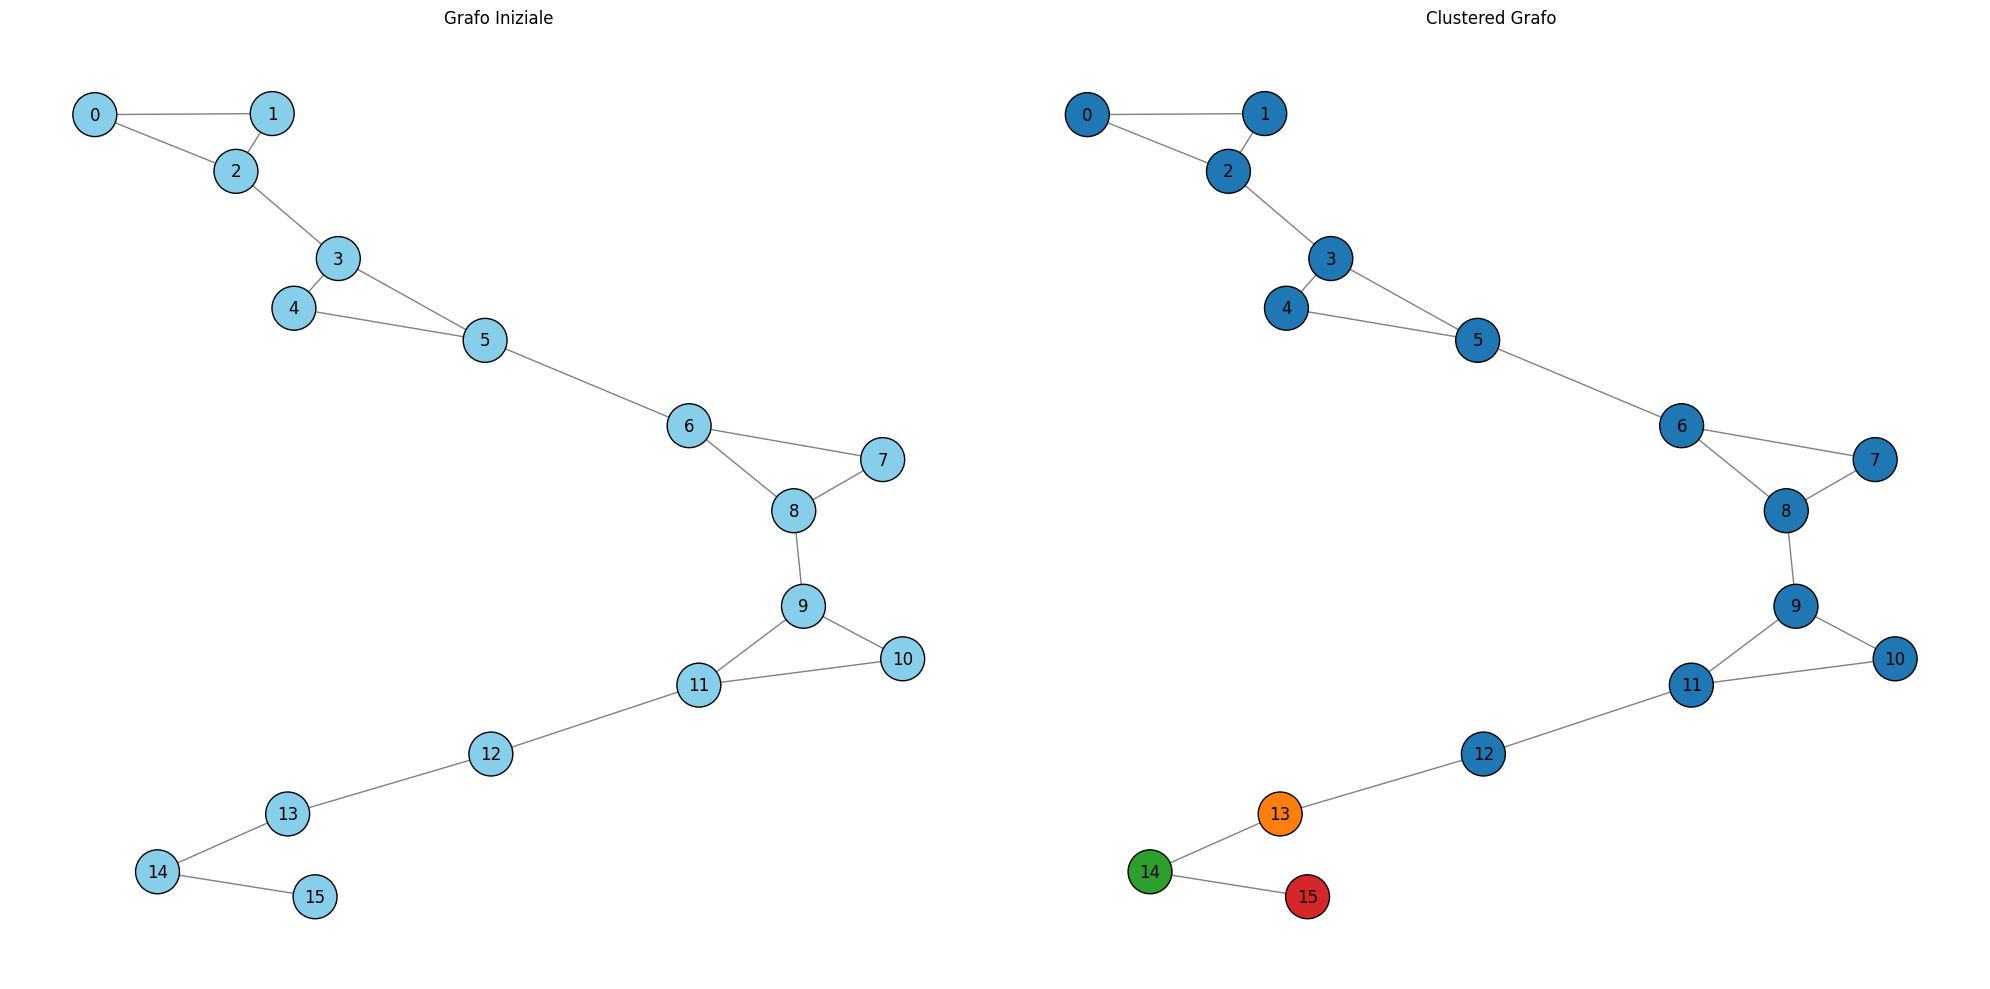

Tempo di esecuzione dell'algoritmo Greedy: 0.018248319625854492 secondi.


In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
    

def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        sottografo = grafo.subgraph(cluster)
        if not nx.is_connected(sottografo):
            return False
    return True

def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut



if __name__ == "__main__":
    grafo = Graph()
    for i in range(16):
        grafo.aggiungi_vertice(i)

    # Aggiungiamo archi per formare 4 cluster distinti
    # Primo cluster
    grafo.aggiungi_arco(0, 1)
    grafo.aggiungi_arco(0, 2)
    grafo.aggiungi_arco(1, 2)

    # Secondo cluster
    grafo.aggiungi_arco(3, 4)
    grafo.aggiungi_arco(3, 5)
    grafo.aggiungi_arco(4, 5)

    # Terzo cluster
    grafo.aggiungi_arco(6, 7)
    grafo.aggiungi_arco(6, 8)
    grafo.aggiungi_arco(7, 8)

    # Quarto cluster
    grafo.aggiungi_arco(9, 10)
    grafo.aggiungi_arco(9, 11)
    grafo.aggiungi_arco(10, 11)

    # Aggiungiamo qualche arco tra i cluster per rendere il grafo connesso
    grafo.aggiungi_arco(2, 3)
    grafo.aggiungi_arco(5, 6)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(11, 12)
    grafo.aggiungi_arco(12, 13)
    grafo.aggiungi_arco(13, 14)
    grafo.aggiungi_arco(14, 15)
    
    print("Grafo iniziale:")
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
   
    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    # clusters = divide_into_clusters(G_initial, k)
    clusters = divide_into_clusters_greedy(G_initial, k)
    dimensione_multicut = calcola_dimensione_multicut(G_initial, clusters)
    ammissibile = è_ammissibile(G_initial, clusters)

    print(f"Ammissibile: {ammissibile}")
    print(f"Clusters: {clusters}")
    print(f"Dimensione del Multicut: {dimensione_multicut}")
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo Greedy: {elapsed_time} secondi.")

# Greedy con Ricerca Locale
L'approccio greedy fornisce una soluzione iniziale che può essere ulteriormente migliorata utilizzando la ricerca locale. L'idea di base della ricerca locale è di esplorare le soluzioni vicine a quella corrente, accettando miglioramenti fino a quando non si può fare meglio.

Uno dei metodi più semplici per la ricerca locale in questo contesto sarebbe di prendere un nodo da un cluster e tentare di spostarlo in un altro cluster, accettando lo spostamento se riduce la dimensione del multicut. Questo processo viene ripetuto fino a quando non sono possibili ulteriori miglioramenti.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
    

def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

# Questa funzione verifica che ogni coppia di nodi in un cluster abbia un percorso nel grafo originale, 
# il che garantisce che il cluster sia una componente connessa del grafo originale.
def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        for u, v in itertools.combinations(cluster, 2):
            if not nx.has_path(grafo, u, v):
                return False
    return True


def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut

def ricerca_locale(grafo, clusters):
    miglioramento = True

    while miglioramento:
        miglioramento = False

        for i, cluster in enumerate(clusters):
            for node in cluster:
                for j, target_cluster in enumerate(clusters):
                    if i != j:
                        # Prova a spostare il nodo al cluster target e verifica se migliora la dimensione del multicut
                        nuovo_clusters = [c[:] for c in clusters]
                        nuovo_clusters[i].remove(node)
                        nuovo_clusters[j].append(node)
                        
                        if calcola_dimensione_multicut(grafo, nuovo_clusters) < calcola_dimensione_multicut(grafo, clusters):
                            clusters = nuovo_clusters
                            miglioramento = True
                            break

                if miglioramento:
                    break

            if miglioramento:
                break

    return clusters


In [ ]:
# ...
clusters = divide_into_clusters_greedy(G_initial, k)
clusters = ricerca_locale(G_initial, clusters)
dimensione_multicut = calcola_dimensione_multicut(G_initial, clusters)


# ...


## Prova raccolta dei tempi con diagramma


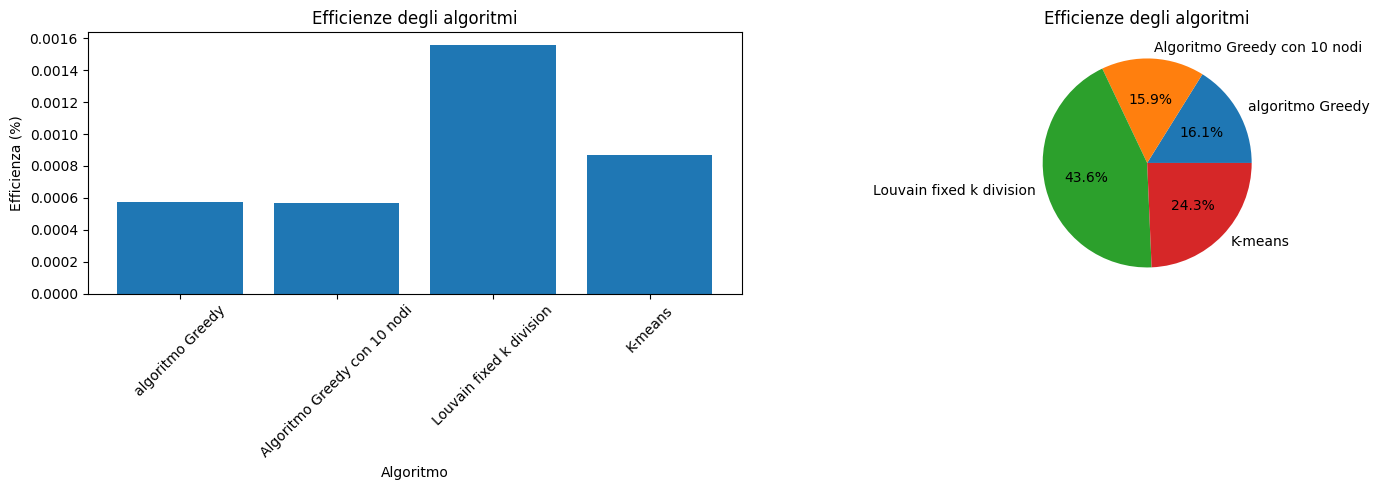

In [18]:
import matplotlib.pyplot as plt

# Supponiamo che questi siano i tuoi dati di efficienza per diversi algoritmi
efficienze = {'algoritmo Greedy': 0.0005772113800048828, 'Algoritmo Greedy con 10 nodi': 0.00057, 'Louvain fixed k division':  0.00156, 'K-means': 0.00087}

# Creazione dei subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Creazione di un diagramma a barre sul primo subplot
axs[0].bar(efficienze.keys(), efficienze.values())
axs[0].set_title('Efficienze degli algoritmi')
axs[0].set_xlabel('Algoritmo')
axs[0].set_ylabel('Efficienza (%)')
axs[0].tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse x per una migliore lettura

# Creazione di un diagramma a torta sul secondo subplot
axs[1].pie(efficienze.values(), labels = efficienze.keys(), autopct='%1.1f%%')
axs[1].set_title('Efficienze degli algoritmi')

plt.tight_layout()  # Assicura un buon spazio tra i subplot
plt.show()
